# Spectral unmixing of fluorescent dyes

Adapted from *Marina Alterman, Yoav Schechner, and Aryeh Weiss, “Multiplexed Fluorescence Unmixing” (2010): 1–8.*


A mixture of $n_{dyes}$ dyes is excited with $S$ different laser line configurations, and the emitted flourescence is measured at $F$ diffrent wavelength bands. For a particular exitation source $s$ and filter band $f$ the corresponding intensity of the image $i_{f,s}$ is given by

$$i_{f,s} = \frac{q_{elect}^{cam}(f)}{g_{gray}^{cam}} \sum_{d=0}^{n_{dyes}} \mathcal{P}\left( N_{d} \left( f,s \right) \right) + \frac{1}{g_{gray}^{cam}} \mathcal{N}\left( 0,\sigma^2_{elect} \right)$$

where

$i_{f,s} \; \left[ \textrm{graylevel} \right]$ gray-scale value of signal in emission filter band $f$ with excitation source $s$.

$g_{gray}^{cam} \; \left[ \textrm{electron} \cdot \textrm{graylevel}^{-1} \right]$ conversion factor from photoelectrons to camera gray-scale values.

$q_{elect}^{cam}(f) \; \left[ \textrm{electron} \cdot \textrm{photon}^{-1} \right]$ quantum efficiency of the detector in filter band $f$.

$n_{dyes} \; \left[ \textrm{int} \right]$ number of dyes.

$N_{d} \left( f,s \right) \; \left[ \textrm{photon} \right]$ expected number of photons from dye $d$ in filter band $f$ with exication source $s$. $N_{0} \left( f,s \right)$ is the expected number of background photons.

$\sigma_{elect} \; \left[ \textrm{electron} \right]$ is the standard deviation of the sensor noise.

$\mathcal{P} \left( \lambda \right)$ is a poisson distribution with rate $\lambda$.

$\mathcal{N} \left( \mu, \sigma^2 \right)$ is a normal distribution with mean $\mu$ and variance $\sigma^2$.



The expected number of photons from dye $d$ in filter band $f$ with exication source $s$ is given by

$$N_{d} \left( f,s \right) = a_{d}(s) m_{d}(f) t^{exp} V c_{d} $$

where

$c_d \; \left[ \textrm{M} \right]$ is the concentration of dye $d$.

$t^{exp} \; \left[ \textrm{sec} \right]$ is the exposure time.

$V \; \left[ \textrm{cm}^3 \right]$ is the volume of a voxel corresponding to one camera pixel.

$m_{d}(f) \; \left[ \% \right]$ is the porportion of absorbed light emitted in filter band $f$.

$a_{d}(f) \; \left[ \textrm{photon} \cdot \textrm{M}^{-1} \cdot \textrm{sec}^{-1} \textrm{cm}^{-3} \right]$ is the rate of photon absorbtion from source $s$ per unit volume per molar concentration.



$$ a_{d}(s) = \epsilon_{d}\int_{\lambda^{ex}} L_{s}(\lambda) \alpha_{d}(\lambda) d\lambda$$

$\epsilon_{d} \; \left[ \textrm{M}^{-1} \cdot \textrm{cm}^{-1} \right]$ is the molar extinction coefficient of dye $d$. It is the absorption of the dye at the wavelength giving strongest absorption.

$L_{s}(\lambda) \; \left[ \textrm{photon} \cdot \textrm{sec}^{-1} \textrm{cm}^{-2} \textrm{nm}^{-1} \right]$ is the spectral intensity distribution of the light source $s$.

$\alpha_{d}(\lambda) \; \left[ \% \right]$ is the peak normalized absorption of dye $d$ at wavelength $\lambda$, i.e. $\max \left[ \alpha_{d}(\lambda) \right] = 1$.

$$ m_{d}(f) = \Phi_{d}\int_{\lambda^{em}} \tau_{f}^{em}(\lambda) e_{d}(\lambda) d\lambda$$

$\Phi_{d} \; \left[ \% \right]$ is the quantum yield for emission by an excited dye $d$. It represents emission probability across the entire spectrum.

$\tau_{f}^{em}(\lambda) \; \left[ \textrm{nm}^{-1} \right]$ is the transmissivity of the optics in the emission path for filter $f$ per unit wavelength.

$e_{d}(\lambda) \; \left[ \% \right]$ is the normalized emission spectrum of dye $d$ at wavelength $\lambda$, i.e. $\int e_{d}(\lambda) d\lambda = 1$.

For the case where the filter band ranges from $f_{min}$ to $f_{max}$ and there is a single wavelength excitation source $s$, then

$$N_{d} \left( f,s \right) \propto \left( \alpha_{d}(s) \int_{f_{min}}^{f_{max}} e_d(\lambda) d\lambda \right) N_{d}^{Total}$$

If multiple excitation laser sources are used simultaneously, the absorption values at those wavelengths can be added.

$N_{d}^{Total} \; \left[ \textrm{int} \right]$ represents the total number of photons that could be collected at the maximum excitation wavelength across the full emission spectrum.



## setup

In [1]:
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

## load spectra

In [3]:
from unmixer import load

In [4]:
dyes = load()

In [5]:
for d in dyes:
    print(d['name'])

Alexa Fluor 488
Alexa Fluor 532
Alexa Fluor 555
Alexa Fluor 568
Alexa Fluor 594
Alexa Fluor 610
Alexa Fluor 635
Alexa Fluor 647
Alexa Fluor 660
Alexa Fluor 680
DAPI
GFP (emerald GFP)


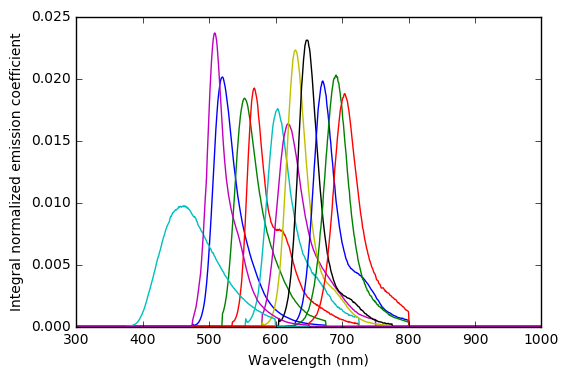

In [6]:
for d in dyes:
    plt.plot(d['spectrum'].Wavelength, d['spectrum'].Emission/d['spectrum'].Emission.sum());
plt.xlabel('Wavelength (nm)');
plt.ylabel('Integral normalized emission coefficient');

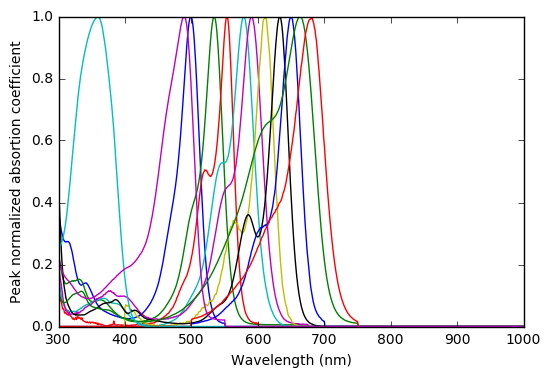

In [7]:
for d in dyes:
    plt.plot(d['spectrum'].Wavelength, d['spectrum'].Excitation/100);
plt.xlabel('Wavelength (nm)');
plt.ylabel('Peak normalized absortion coefficient');
plt.ylim([0, 1]);

## choice of laser lines and filters

In [8]:
from numpy import linspace
laser_lines = [355, 488, 532, 568, 594, 640, 680]
#laser_lines = linspace(350, 700, 32).astype(int)

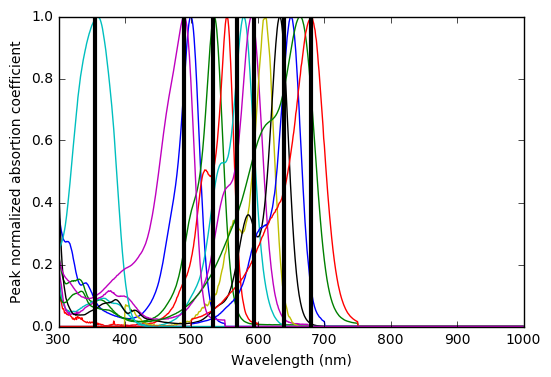

In [9]:
for d in dyes:
    plt.plot(d['spectrum'].Wavelength, d['spectrum'].Excitation/100);
for c in laser_lines:
    plt.plot([c, c], [0, 1], 'k', lw=3)
plt.xlabel('Wavelength (nm)');
plt.ylabel('Peak normalized absortion coefficient');
plt.ylim([0, 1]);

In [86]:
from numpy import linspace
filter_bands = linspace(400, 700, 32).astype(int)
#filter_bands = [400, 700]

In [93]:
from unmixer import convert
coeffs_spectra = [convert(laser_lines, filter_bands, d['spectrum'], sum_lasers=False) for d in dyes]

## simulation

In [94]:
from unmixer import generate, infer, compare, run

In [107]:
# create coefficients and configuration
# could optionally load from JSON files (see test/resources for examples)

coeff = {'emission': [x[1] for x in coeffs_spectra],
         'excitation': [x[0] for x in coeffs_spectra],
         'noise': 1.6, #rms error
         'graylevel' : 37000.0/2**16, #dynamic range 37,000 and 16-bit AD converter
         'qe' : 0.82 #max qe
        }
counts = [0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0]
counts = [5000*c+100 for c in counts]

In [108]:
results = run(coeff, counts, 1000, constrained = True)

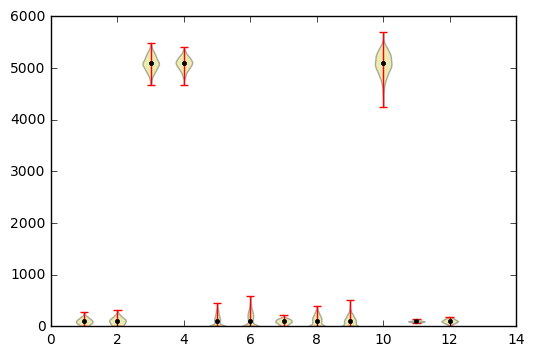

In [109]:
plt.violinplot(results);
plt.plot([x+1 for x in range(len(counts))], counts, '.k');
#plt.ylim([-200, 12000]);

In [92]:
signal = generate(counts, coeff)
estimate = infer(signal, coeff, constrained = True)
accuracy = compare(estimate, counts)

print(accuracy/asarray(counts).sum())

NameError: name 'asarray' is not defined